## Example 3D stitching workflow

This notebook uses the 3D example dataset provided by BigStitcher: https://imagej.net/plugins/bigstitcher/#example-datasets.

This notebook
- downloads the example dataset (6 tiles, 3 channels)
- converts its tif files into [OME-Zarr files](https://www.nature.com/articles/s41592-021-01326-w), which include translation metadata placing the input tiles onto a regular grid (serving as an approximate starting point for the registration)
- (optionally) performs channel alignment / registration
- registers the tiles using one of the input channels
- displays the obtained transformation parameters
- fuses the tiles into a single image (average fusion with blending between tiles)
- saves the fused image in OME-Zarr and tif formats

Notes:
- set `VISUALIZE_USING_NAPARI = True` in the first code cell to use `napari-stitcher` for visualization (needs to be installed separately)

In [1]:
# imports

import os
import zipfile
import xarray as xr
from pathlib import Path

import dask.diagnostics
import ngff_zarr
import numpy as np
import tifffile
from multiview_stitcher import (
    fusion,
    io,
    msi_utils,
    ngff_utils,
    param_utils,
    registration,
    spatial_image_utils,
)
from tqdm import tqdm

# napari-stitcher is required for visualization with napari
VISUALIZE_USING_NAPARI = False

if VISUALIZE_USING_NAPARI:
    import napari
    from napari_stitcher import viewer_utils

2024-02-12 14:27:23,743 [Geometry3D WARNING] 'Renderer' is deprecated, using 'Visualizer' instead.


## Download example data

In [2]:
url = "https://preibischlab.mdc-berlin.de/BigStitcher/Grid_3d.zip"

base_dir = './%s' %os.path.basename(url)[:-4]
os.makedirs(base_dir, exist_ok=True)

zip_filepath = os.path.join(base_dir, os.path.basename(url))

# download
if not os.path.exists(zip_filepath):
    from urllib.request import urlretrieve
    urlretrieve(url, zip_filepath)

# unzip
with zipfile.ZipFile(os.path.join(base_dir, os.path.basename(url)), 'r') as zip_ref:
    zip_ref.extractall(base_dir)

# get the list of files
sorted(Path(base_dir).glob('*/*.tif'))

[PosixPath('Grid_3d/Grid1/C1-73.tif'),
 PosixPath('Grid_3d/Grid1/C1-74.tif'),
 PosixPath('Grid_3d/Grid1/C1-75.tif'),
 PosixPath('Grid_3d/Grid1/C1-76.tif'),
 PosixPath('Grid_3d/Grid1/C1-77.tif'),
 PosixPath('Grid_3d/Grid1/C1-78.tif'),
 PosixPath('Grid_3d/Grid1/C2-73.tif'),
 PosixPath('Grid_3d/Grid1/C2-74.tif'),
 PosixPath('Grid_3d/Grid1/C2-75.tif'),
 PosixPath('Grid_3d/Grid1/C2-76.tif'),
 PosixPath('Grid_3d/Grid1/C2-77.tif'),
 PosixPath('Grid_3d/Grid1/C2-78.tif'),
 PosixPath('Grid_3d/Grid1/C3-73.tif'),
 PosixPath('Grid_3d/Grid1/C3-74.tif'),
 PosixPath('Grid_3d/Grid1/C3-75.tif'),
 PosixPath('Grid_3d/Grid1/C3-76.tif'),
 PosixPath('Grid_3d/Grid1/C3-77.tif'),
 PosixPath('Grid_3d/Grid1/C3-78.tif')]

## Specify input files

In [3]:
# indicate the tiles and channels to process
tiles = np.arange(73, 79)
channels = np.arange(1, 4)

def get_filename_from_tile_and_channel(tile, channel):
    """
    This convenience function returns the filename given the tile and channel.
    """
    return f'./Grid_3d/Grid1/C{channel:01d}-{tile:02d}.tif'

print('Example filename:\n', get_filename_from_tile_and_channel(tiles[0], channels[0]))

Example filename:
 ./Grid_3d/Grid1/C1-73.tif


## Read input data and convert to OME-Zarr

This includes (pre-)arranging the tiles on a grid.
Make sure to indicate `scale`, `tile_grid_position` and `overlap`.

In [4]:
overwrite = True

msims = []
for tile_index, tile in tqdm(enumerate(tiles[:])):

    # where to save the zarr(s)
    zarr_path = os.path.join(os.path.dirname(get_filename_from_tile_and_channel(tile, channels[0])),
                             f'tile_{tile:02d}')

    # if zarr doesn't exist yet, create it
    if not os.path.exists(zarr_path) or overwrite:

        # indicate pixel spacing
        scale = {'z': 5, 'y': 1, 'x': 1}

        # indicate grid position for current tile index
        # (as a function of the tile index)
        tile_grid_position = {
            'z': 0,
            'y': tile_index // 2,
            'x': tile_index % 2,
        }

        # indicate approximate overlap between tiles
        overlap = 0.1 # relative to image shape

        # read tile image
        im_data = np.array([
            tifffile.imread(get_filename_from_tile_and_channel(tile, ch))
            for ch in channels])

        shape = {dim: im_data.shape[-idim] for idim, dim in enumerate(scale.keys())}
        translation = {dim: tile_grid_position[dim] * (1 - overlap) * shape[dim] * scale[dim]
                    for dim in scale}

        ngff_im = ngff_zarr.NgffImage(
            im_data,
            dims=('c', 'z', 'y', 'x'),
            scale=scale,
            translation=translation,
            )

        ngff_multiscales = ngff_zarr.to_multiscales(ngff_im)

        ngff_zarr.to_ngff_zarr(zarr_path, ngff_multiscales)

    # open tile image from zarr on disk
    msim = ngff_utils.ngff_multiscales_to_msim(
        ngff_zarr.from_ngff_zarr(zarr_path),
        transform_key=io.METADATA_TRANSFORM_KEY)

    msims.append(msim)

6it [00:12,  2.07s/it]


In case of starting from OME-Zarr data (which includes positional metadata), skip the previous cell and read input data as follows:

In [5]:
# # Input file names
# zarr_tile_paths = ['tile1.zarr', 'tile2.zarr']

# msims = [
#     ngff_utils.ngff_multiscales_to_msim(
#         ngff_zarr.from_ngff_zarr(zarr_tile_path),
#         transform_key=io.METADATA_TRANSFORM_KEY
#         )
#         for zarr_tile_path in zarr_tile_paths]

### Visualize pre-registered views

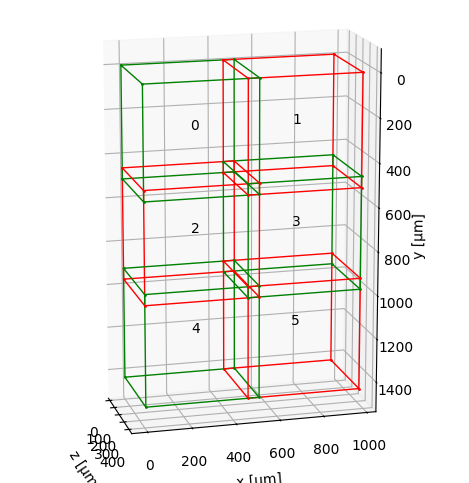

In [6]:
# visualize tile positions/configuration

# uncomment the following line for 3D interactivity with
# the plot (requires ipympl to be installed)

# % matplotlib widget

from multiview_stitcher import vis_utils

fig, ax = vis_utils.plot_positions(
    msims,
    use_positional_colors=True, # set to False for faster execution in case of more than 20 tiles/views
    transform_key='affine_metadata'
    )

In [7]:
# using napari

if VISUALIZE_USING_NAPARI:

    ch_coord = 0 # None if all should be shown

    viewer = napari.Viewer(ndisplay=msi_utils.get_ndim(msims[0]))
    lds = viewer_utils.create_image_layer_tuples_from_msims(
        msims, ch_coord=ch_coord, transform_key='affine_metadata', n_colors=2, contrast_limits=[0, 500])
    viewer_utils.add_image_layer_tuples_to_viewer(viewer, lds)
    viewer.reset_view()


### Align channels (optional)

Perform channel alignment prior to view/tile registration to account for shifts between channels in the input data.
The example data does not exhibit significant channel shifts, but this might be useful for other datasets.

In [8]:
# Turn channel alignment on or off
perform_channel_alignment = False

# Channel alignment is performed using a single tile.
# Choose here which tile (index) to use.
channel_alignment_tile_index = 0

curr_transform_key = 'affine_metadata'
if perform_channel_alignment:
    curr_transform_key = 'affine_metadata_ch_reg'

    channels = msims[channel_alignment_tile_index]['scale0/image'].coords['c']

    # select chosen tiles for registration
    msims_ch_reg = [msi_utils.multiscale_sel_coords(msims[5], {'c': ch})
                    for ch in channels]

    with dask.diagnostics.ProgressBar():
        params_c = registration.register(
            msims_ch_reg,
            registration_binning={'z': 2, 'y': 4, 'x': 4},
            reg_channel_index=0,
            transform_key='affine_metadata',
            pre_registration_pruning_method=None,
        )

    # assign channel coordinates to obtained parameters
    params_c = xr.concat(params_c, dim='c').assign_coords({'c': channels})

    # set obtained parameters for all tiles
    for msim in msims:
        msi_utils.set_affine_transform(
            msim, params_c, transform_key=curr_transform_key, base_transform_key='affine_metadata')


### Register views

In [9]:
with dask.diagnostics.ProgressBar():

    params = registration.register(
        msims,
        registration_binning={'z': 1, 'y': 3, 'x': 3},
        reg_channel_index=0,
        transform_key=curr_transform_key,
        new_transform_key='affine_registered',
    )

[########################################] | 100% Completed | 6.62 sms


In [10]:
# print the obtained parameters
# how to interpret these?
#   - parameters are expressed in homogeneous matrices of dimensions (n+1, n+1)
#   - the first n rows and columns correspond to the linear part of the transformation
#   - the first three elements of the last column correspond to the translation in (z, y, x)
#   - the parameters map the coordinates of the input files (considering their scale and translation)
#     into a world coordinate system in which the tiles are registered

for imsim, msim in enumerate(msims):
    affine = np.array(msi_utils.get_transform_from_msim(msim, transform_key='affine_registered')[0])
    print(f'tile index {imsim}\n', affine)

tile index 0
 [[ 1.   0.   0.   0. ]
 [ 0.   1.   0.   5.5]
 [ 0.   0.   1.  -2. ]
 [ 0.   0.   0.   1. ]]
tile index 1
 [[ 1.   0.   0.   0. ]
 [ 0.   1.   0.   5.5]
 [ 0.   0.   1.  -1. ]
 [ 0.   0.   0.   1. ]]
tile index 2
 [[ 1.   0.   0.   0. ]
 [ 0.   1.   0.  -1.5]
 [ 0.   0.   1.  -1. ]
 [ 0.   0.   0.   1. ]]
tile index 3
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
tile index 4
 [[ 1.   0.   0.   0. ]
 [ 0.   1.   0.  -4.5]
 [ 0.   0.   1.  -1. ]
 [ 0.   0.   0.   1. ]]
tile index 5
 [[ 1.   0.   0.   0. ]
 [ 0.   1.   0.  -4.5]
 [ 0.   0.   1.   0. ]
 [ 0.   0.   0.   1. ]]


### Visualize registration

In [11]:
if VISUALIZE_USING_NAPARI:

    viewer = napari.Viewer(ndisplay=msi_utils.get_ndim(msims[0]))

    ch_coord = 0 # None if all should be shown

    lds = viewer_utils.create_image_layer_tuples_from_msims(
        msims, ch_coord=ch_coord, transform_key='affine_registered', n_colors=2,
        name_prefix='registered view',
        contrast_limits=[0, 500],
        )
    rlayers = viewer_utils.add_image_layer_tuples_to_viewer(viewer, lds, do_link_layers=True)

    viewer.reset_view()

### Fuse views (linear blending)
#### Save output into OME-Zarr

In [12]:
output_dir = base_dir
output_filename = os.path.join(output_dir, 'fused.zarr')

fused = fusion.fuse(
    [msi_utils.get_sim_from_msim(msim) for msim in msims],
    transform_key='affine_registered',
    output_chunksize=256,
    )

print(f'Fusing views and saving output to {output_filename}...')
with dask.diagnostics.ProgressBar():

    fused_ngff = ngff_utils.sim_to_ngff_image(
        fused,
        transform_key='affine_registered')

    fused_ngff_multiscales = ngff_zarr.to_multiscales(fused_ngff, scale_factors=[])

    ngff_zarr.to_ngff_zarr(
        output_filename,
        fused_ngff_multiscales,
        )

mfused = ngff_utils.ngff_multiscales_to_msim(
    ngff_zarr.from_ngff_zarr(output_filename),
    transform_key='affine_registered')


Fusing views and saving output to ./Grid_3d/fused.zarr...
[########################################] | 100% Completed | 84.04 s


### Visualize fusion in napari

In [13]:
if VISUALIZE_USING_NAPARI:

    viewer = napari.Viewer(ndisplay=msi_utils.get_ndim(msims[0]))

    ch_coord = None

    lds = viewer_utils.create_image_layer_tuples_from_msims(
        [mfused],
        ch_coord=ch_coord,
        transform_key='affine_registered',
        name_prefix='fused',
        contrast_limits=[0, 500])

    viewer_utils.add_image_layer_tuples_to_viewer(viewer, lds)

In [14]:
# stream fused image into tif
# i.e. convert OME-Zarr output into tif

output_filename = os.path.join(output_dir, 'fused.tif')

print(f'Streaming into {output_filename}...')
with dask.diagnostics.ProgressBar():
    io.save_sim_as_tif(
        output_filename,
        msi_utils.get_sim_from_msim(mfused))

Streaming into ./Grid_3d/fused.tif...


  0%|          | 0/3 [00:00<?, ?it/s]

[########################################] | 100% Completed | 1.51 sms


 33%|███▎      | 1/3 [00:02<00:04,  2.05s/it]

[########################################] | 100% Completed | 1.22 sms


 67%|██████▋   | 2/3 [00:03<00:01,  1.88s/it]

[########################################] | 100% Completed | 1.11 sms


100%|██████████| 3/3 [00:05<00:00,  1.82s/it]
